In [1]:
import numpy as np
from pathlib import Path
import scipy.io as sio
from scipy.interpolate import interp2d
import imageio
import cv2
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import time

from skimage import data, draw
from skimage.registration import phase_cross_correlation
import skimage.io
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.transform import warp

from spyrit.misc.disp import *
from spyrit.misc.metrics import *
from spyrit.learning.dataset import *


In [2]:
from scipy.interpolate import griddata, RectBivariateSpline
from scipy.linalg import block_diag

def warp_zero(I1, flow):
    nr, nc = I1.shape
    row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
    image1_warp = warp(I1, np.array([row_coords - flow[:,:,0], col_coords - flow[:,:,1]]), mode='edge', preserve_range=True);
    return image1_warp;

def warp_un(I1, flow):
    nx, ny = I1.shape
    x = np.linspace(1, nx, nx);
    y = np.linspace(1, ny, ny);
    X, Y = np.meshgrid(x, y);
    I2 = griddata((np.reshape(X,(nx*ny)),np.reshape(Y,(nx*ny))), np.reshape(I1,(nx*ny)), (X+flow[:,:,0],Y+flow[:,:,1]), method='cubic');
    I2[np.isnan(I2)] = I1[np.isnan(I2)]
    return I2;

def warp_bis(I1, flow):
    """Bonne fonction pour faire ce qui nous intéresse!"""
    h, w = flow.shape[:2];
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    I2 = cv2.remap(I1, flow, None, cv2.INTER_LINEAR);
    return I2;

def warp_trois(I1, flow):
    nx, ny = I1.shape
    x = np.linspace(1, nx, nx);
    y = np.linspace(1, ny, ny);
    X, Y = np.meshgrid(x, y);
    I2 = griddata((np.reshape(X,(nx*ny)),np.reshape(Y,(nx*ny))), np.reshape(I1,(nx*ny)), (X+flow[:,:,0],Y+flow[:,:,1]), method='cubic', fill_value = 0);
    return I2;


def float2_bit(I):
    I_8_bit = 255*(I+1)/2
    I_8_bit = I_8_bit.astype('uint8')
    return I_8_bit

def float2_bit_gen(I):
    I_8_bit = 255*(I-np.amin(I))/(np.amax(I)-np.amin(I))
    I_8_bit = I_8_bit.astype('uint8')
    return I_8_bit

# Test on synthetic video

In [3]:
def boule_vid_parabola(n, r, n_frames, v):
    x = np.linspace(-1, 1, n);
    y = np.linspace(-1, 1, n);
    X, Y = np.meshgrid(x, y);
    Vid = np.zeros((n_frames,n,n))
    for i in range(n_frames):
        t = v*i/n_frames;
        x_c = t;
        y_c =  t*(t-1);
        msk = 1.0*((X-x_c)**2+(Y-y_c)**2<r);
        Vid[i,:,:] = msk;
    return Vid;

## Visualising video fast

In [4]:
n_frames = 10;
A = boule_vid_parabola(64, 0.025, n_frames, 1)
A = torch.Tensor(A);
A = torch2numpy(A)

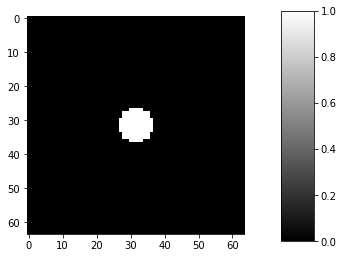

In [5]:
imagesc(A[0,:,:])

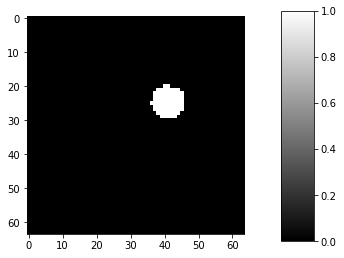

In [6]:
imagesc(A[3,:,:])

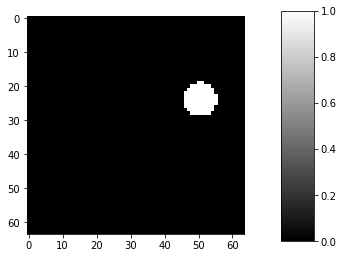

In [7]:
imagesc(A[6,:,:])

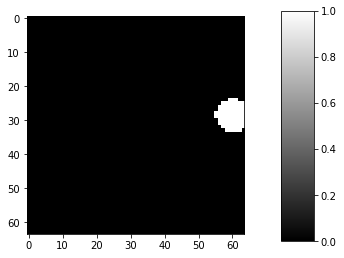

In [8]:
imagesc(A[9,:,:])

In [9]:
I1 = A[0,:,:].astype(np.float32);
I2 = A[1,:,:].astype(np.float32);
I1_8_bit = float2_bit(I1);
I2_8_bit = float2_bit(I2);

## TV + Horn-Shunk

In [10]:
optical_flow = cv2.optflow.DualTVL1OpticalFlow_create(nscales=1,epsilon=0.05,warps=1, innnerIterations = 10);
optical_flow.setLambda(0.005) #0.005 is the breaking point
t1 = time.time();
flow = optical_flow.calc(I1, I2, None);
# flow = optical_flow.calc(I1_8_bit, I2_8_bit, None);
t2 = time.time();

In [11]:
t2-t1

0.010489225387573242

In [12]:
u = flow[:,:,0];
v = flow[:,:,1];

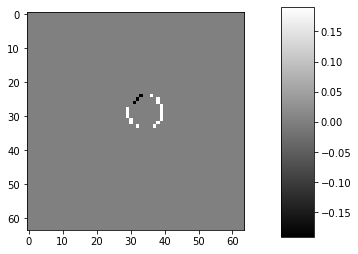

In [13]:
imagesc(u)

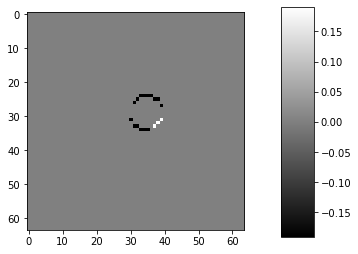

In [14]:
imagesc(v)

Flot Optique trop faible! 0.15 pixels n'est pas réaliste...

In [15]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

print("===========================================");
print("Warp error Skimage - = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy - = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv - = " + str(np.linalg.norm(I2-I2_bis_check)));
print("Warp error scipy-bis - = " + str(np.linalg.norm(I2-I2_ter_check)));
print("===========================================");

Identity error = 9.110434
Warp error Skimage - = 9.110434
Warp error scipy - = 9.10007209927984
Warp error opencv - = 9.073054
Warp error scipy-bis - = 9.10007209927984


## Farneback method

In [16]:
t1 = time.time();
# flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 2, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 4 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 
flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 10, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 10 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 
t2 = time.time();

In [17]:
t2-t1

0.02120804786682129

In [18]:
u = flow[:,:,0];
v = flow[:,:,1];

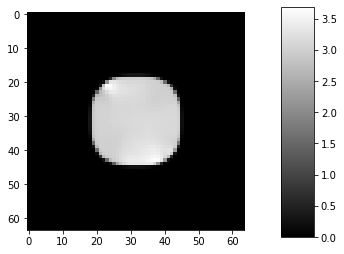

In [19]:
imagesc(u)

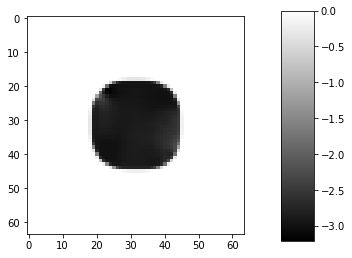

In [20]:
imagesc(v)

Going 3 pixels up and to the right seems more correct...

In [21]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

print("===========================================");
print("Warp error Skimage - = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy - = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv - = " + str(np.linalg.norm(I2-I2_bis_check)));
print("Warp error scipy-bis - = " + str(np.linalg.norm(I2-I2_ter_check)));
print("===========================================");

Identity error = 9.110434
Warp error Skimage - = 1.9683554
Warp error scipy - = 1.4678077235554285
Warp error opencv - = 1.3900365
Warp error scipy-bis - = 1.4678077235554285


Very low error accross the board!

## Lucas-Kanade + sparse-to dense

In [22]:
np.random.seed(seed=1)
t1 = time.time();
flow = cv2.optflow.calcOpticalFlowSparseToDense(I1_8_bit, I2_8_bit, None); # Pas forcément top ici!!
t2 = time.time();

In [23]:
t2-t1

0.009613990783691406

In [24]:
u = flow[:,:,0];
v = flow[:,:,1];

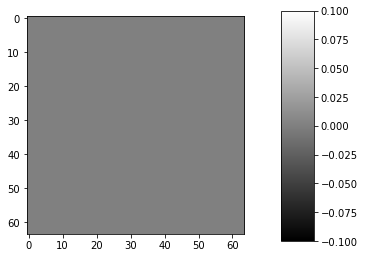

In [25]:
imagesc(u)

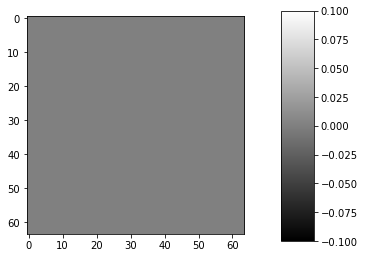

In [26]:
imagesc(v)

Ne nous va pas du tout dans ce cas précis! Lucas Kanade utilise des points clé pour définir dans quelle direction se propage le flot pour ces points clé, donc ici il a dû rater la boule.

In [27]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

print("===========================================");
print("Warp error Skimage - = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy - = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv - = " + str(np.linalg.norm(I2-I2_bis_check)));
print("Warp error scipy-bis - = " + str(np.linalg.norm(I2-I2_ter_check)));
print("===========================================");

Identity error = 9.110434
Warp error Skimage - = 9.110434
Warp error scipy - = 9.1104335791443
Warp error opencv - = 9.110434
Warp error scipy-bis - = 9.1104335791443


## Visualisation of results on the Farneback algorithm

In [28]:
t1 = time.time();
flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 2, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 4 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 
t2 = time.time();

In [29]:
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

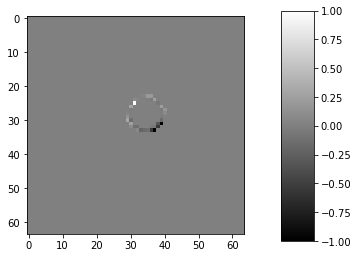

2.0989835


In [30]:
imagesc(I2_zero_check-I2)
print(np.linalg.norm(I2-I2_zero_check))

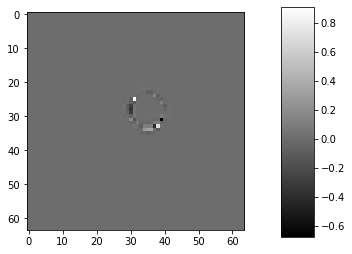

1.6868653793637425


In [31]:
imagesc(I2_un_check-I2)
print(np.linalg.norm(I2-I2_un_check))

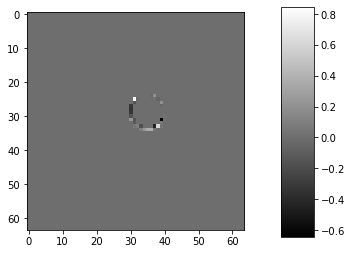

1.6222813


In [32]:
imagesc(I2_bis_check-I2)
print(np.linalg.norm(I2-I2_bis_check))

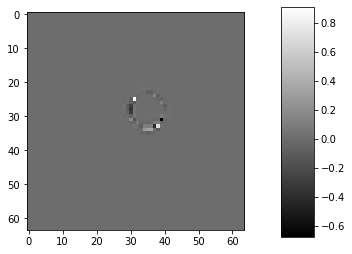

1.6868653793637425


In [33]:
imagesc(I2_ter_check-I2)
print(np.linalg.norm(I2-I2_ter_check))

## Visualising video (slow)

In [34]:
n_frames = 100;
A = boule_vid_parabola(64, 0.025, n_frames, 1)
A = torch.Tensor(A);
A = torch2numpy(A)

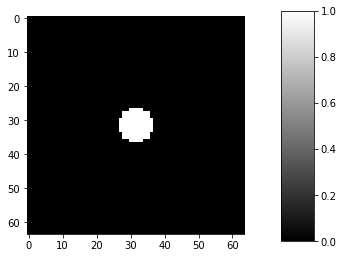

In [35]:
imagesc(A[0,:,:])

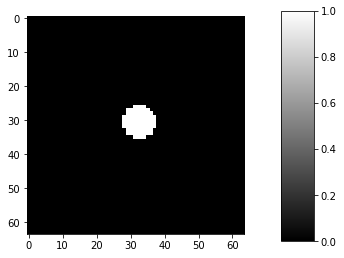

In [36]:
imagesc(A[3,:,:])

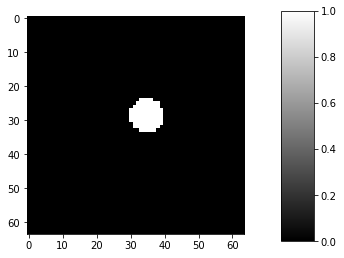

In [37]:
imagesc(A[10,:,:])

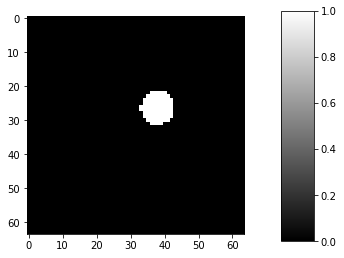

In [38]:
imagesc(A[20,:,:])

In [39]:
I1 = A[0,:,:].astype(np.float32);
I2 = A[1,:,:].astype(np.float32);

In [40]:
I1_8_bit = float2_bit(I1);
I2_8_bit = float2_bit(I2);

## TV + Horn-Shunk

In [41]:
optical_flow = cv2.optflow.DualTVL1OpticalFlow_create(nscales=1,epsilon=0.05,warps=1, innnerIterations = 10);
optical_flow.setLambda(0.005) #0.005 is the breaking point
t1 = time.time();
flow = optical_flow.calc(I1, I2, None);
# flow = optical_flow.calc(I1_8_bit, I2_8_bit, None);
t2 = time.time();

In [42]:
t2-t1

0.0009777545928955078

In [43]:
u = flow[:,:,0];
v = flow[:,:,1];

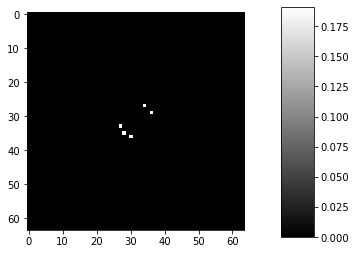

In [44]:
imagesc(u)

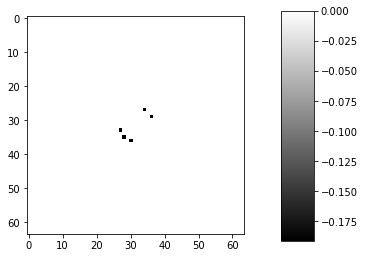

In [45]:
imagesc(v)

In [46]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

print("===========================================");
print("Warp error Skimage - = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy - = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv - = " + str(np.linalg.norm(I2-I2_bis_check)));
print("Warp error scipy-bis - = " + str(np.linalg.norm(I2-I2_ter_check)));
print("===========================================");

Identity error = 2.236068
Warp error Skimage - = 1.4625597
Warp error scipy - = 1.5892803958086967
Warp error opencv - = 1.4761542
Warp error scipy-bis - = 1.5892803958086967


## Farneback method

In [47]:
t1 = time.time();
# flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 2, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 4 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 
flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 10, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 10 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 
t2 = time.time();

In [48]:
t2-t1

0.0013518333435058594

In [49]:
u = flow[:,:,0];
v = flow[:,:,1];

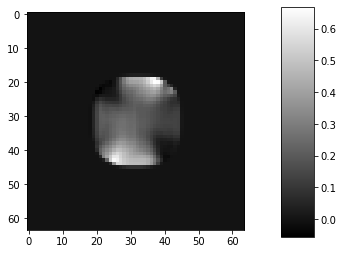

In [50]:
imagesc(u)

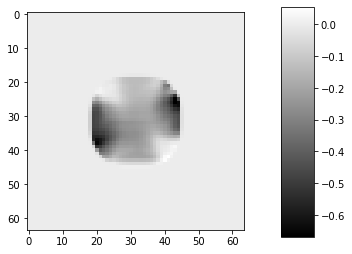

In [51]:
imagesc(v)

In [52]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

print("===========================================");
print("Warp error Skimage - = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy - = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv - = " + str(np.linalg.norm(I2-I2_bis_check)));
print("Warp error scipy-bis - = " + str(np.linalg.norm(I2-I2_ter_check)));
print("===========================================");

Identity error = 2.236068
Warp error Skimage - = 1.709342
Warp error scipy - = 1.7078959703190935
Warp error opencv - = 1.65687
Warp error scipy-bis - = 1.7078959703190935


Very low error accross the board!

## Lucas-Kanade + sparse-to dense

In [53]:
np.random.seed(seed=1)
t1 = time.time();
flow = cv2.optflow.calcOpticalFlowSparseToDense(I1_8_bit, I2_8_bit, None); # Pas forcément top ici!!
t2 = time.time();

In [54]:
t2-t1

0.0021491050720214844

In [55]:
u = flow[:,:,0];
v = flow[:,:,1];

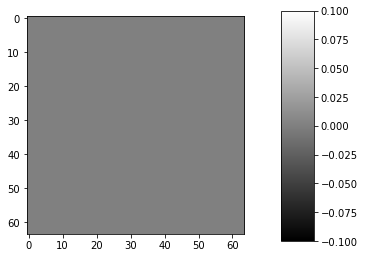

In [56]:
imagesc(u)

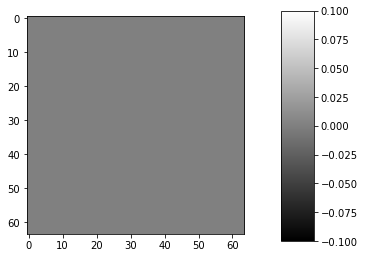

In [57]:
imagesc(v)

Ne nous va pas du tout dans ce cas précis! Lucas Kanade utilise des points clé pour définir dans quelle direction se propage le flot pour ces points clé, donc ici il a dû rater la boule.

In [58]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

print("===========================================");
print("Warp error Skimage - = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy - = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv - = " + str(np.linalg.norm(I2-I2_bis_check)));
print("Warp error scipy-bis - = " + str(np.linalg.norm(I2-I2_ter_check)));
print("===========================================");

Identity error = 2.236068
Warp error Skimage - = 2.236068
Warp error scipy - = 2.23606797749979
Warp error opencv - = 2.236068
Warp error scipy-bis - = 2.23606797749979


## Visualisation of results on the Farneback algorithm

In [59]:
t1 = time.time();
flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 2, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 4 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 
t2 = time.time();

In [60]:
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

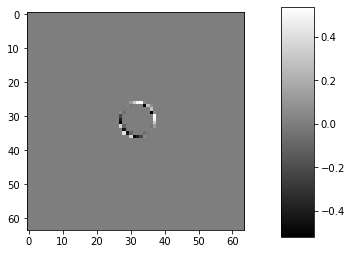

1.9300618


In [61]:
imagesc(I2_zero_check-I2)
print(np.linalg.norm(I2-I2_zero_check))

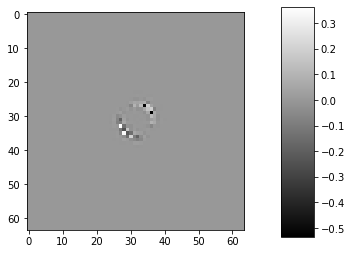

1.183815164832446


In [62]:
imagesc(I2_un_check-I2)
print(np.linalg.norm(I2-I2_un_check))

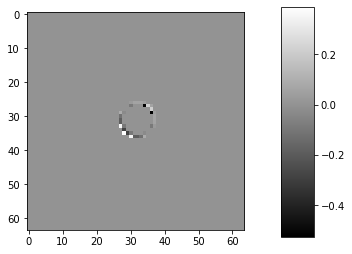

1.2127295


In [63]:
imagesc(I2_bis_check-I2)
print(np.linalg.norm(I2-I2_bis_check))

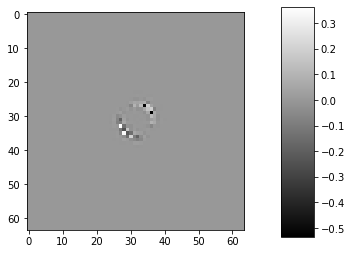

1.183815164832446


In [64]:
imagesc(I2_ter_check-I2)
print(np.linalg.norm(I2-I2_ter_check))

# Test on Real Videos (slow)

In [65]:
data_root = "../../data/UCF-101";
dataset_path="../../data/UCF-101-frames";
split_path="../../data/ucfTrainTestlist";
batch_size=20;
img_size=64;
num_frames=21;
# dt = 1/25;
# dx = 1/img_size;

np.random.seed(seed=0)

In [66]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.FloatTensor;
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
image_shape = (1, img_size, img_size)




# Define training set
train_dataset = Dataset_prediction(
    dataset_path = dataset_path,
    split_path = split_path,
    split_number = 1,
    input_shape = image_shape,
    sequence_length = num_frames,
    training = True,
)
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4)
# Define test set
test_dataset = Dataset_prediction(
    dataset_path = dataset_path,
    split_path = split_path,
    split_number = 1,
    input_shape = image_shape,
    sequence_length = num_frames,
    training=False,
)
testloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 4)
dataloaders = {'train':trainloader, 'val':testloader};

/home/lorente/.conda/envs/spyrit-env/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [67]:
A = next(iter(testloader));

In [68]:
x = A[0][0,:,:,:,:];
I1 = torch2numpy(x[3,0,:,:]);
I2 = torch2numpy(x[4,0,:,:]);

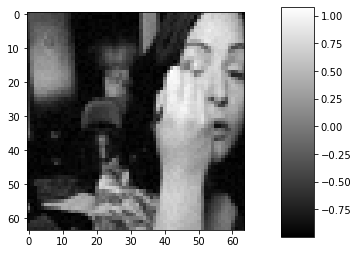

In [69]:
imagesc(I1)

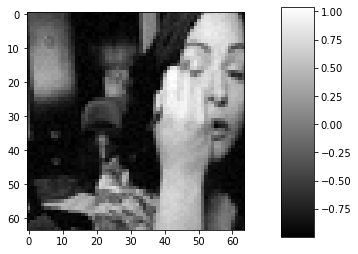

In [70]:
imagesc(I2)

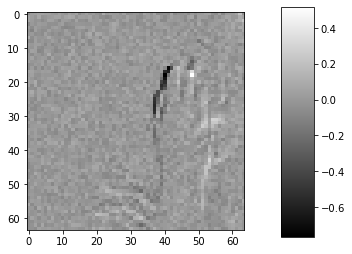

In [71]:
imagesc(I1-I2)

In [72]:
optical_flow = cv2.optflow.DualTVL1OpticalFlow_create(nscales=1,epsilon=0.05,warps=1, innnerIterations = 10);
optical_flow.setLambda(0.005) #0.005 is the breaking point
t1 = time.time();
flow = optical_flow.calc(I1, I2, None);
t2 = time.time();

In [73]:
t2-t1

0.0019383430480957031

In [74]:
u = flow[:,:,0];
v = flow[:,:,1];

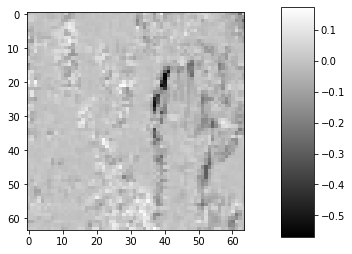

In [75]:
imagesc(u)

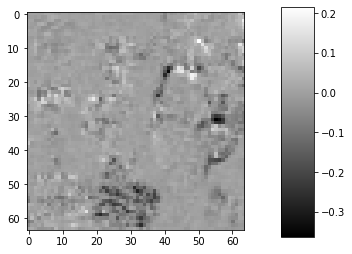

In [76]:
imagesc(v)

In [77]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

print("===========================================");
print("Warp error Skimage - = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy - = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv - = " + str(np.linalg.norm(I2-I2_bis_check)));
print("Warp error scipy-bis - = " + str(np.linalg.norm(I2-I2_ter_check)));
print("===========================================");

Identity error = 4.3338737
Warp error Skimage - = 4.9223747
Warp error scipy - = 2.8435817926569014
Warp error opencv - = 2.9490647
Warp error scipy-bis - = 9.069348147203392


In [78]:
I1_8_bit = float2_bit(I1);
I2_8_bit = float2_bit(I2);


# I1_8_bit = 255*(I1+1)/2
# I1_8_bit = I1_8_bit.astype('uint8')
# I2_8_bit = 255*(I2+1)/2
# I2_8_bit = I2_8_bit.astype('uint8')

In [79]:
t1 = time.time();
flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 10, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 10 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 
t2 = time.time();

In [80]:
t2-t1

0.00087738037109375

In [81]:
u = flow[:,:,0];
v = flow[:,:,1];

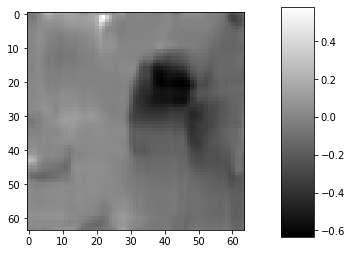

In [82]:
imagesc(u)

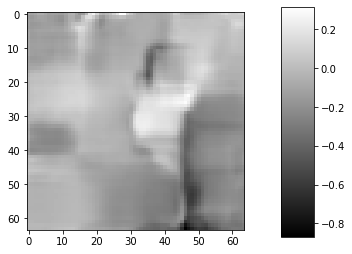

In [83]:
imagesc(v)

In [84]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

print("===========================================");
print("Warp error Skimage - = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy - = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv - = " + str(np.linalg.norm(I2-I2_bis_check)));
print("Warp error scipy-bis - = " + str(np.linalg.norm(I2-I2_ter_check)));
print("===========================================");

Identity error = 4.3338737
Warp error Skimage - = 5.5257864
Warp error scipy - = 3.003193873032363
Warp error opencv - = 3.5658689
Warp error scipy-bis - = 9.622266305115561


In [85]:
np.random.seed(seed=1)
t1 = time.time();
flow = cv2.optflow.calcOpticalFlowSparseToDense(I1_8_bit, I2_8_bit, None); # Pas forcément top
t2 = time.time();

In [86]:
t2-t1

0.002690553665161133

In [87]:
u = flow[:,:,0];
v = flow[:,:,1];

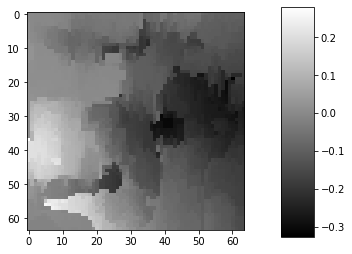

In [88]:
imagesc(u)

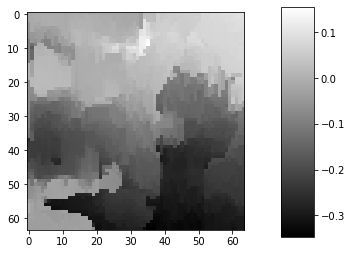

In [89]:
imagesc(v)

In [90]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

print("===========================================");
print("Warp error Skimage - = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy - = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv - = " + str(np.linalg.norm(I2-I2_bis_check)));
print("Warp error scipy-bis - = " + str(np.linalg.norm(I2-I2_ter_check)));
print("===========================================");

Identity error = 4.3338737
Warp error Skimage - = 5.512589
Warp error scipy - = 3.8959669721202634
Warp error opencv - = 4.2334146
Warp error scipy-bis - = 10.132408632652009


## Visualisation of results on the Farneback algorithm

In [91]:
t1 = time.time();
flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 10, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 10 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 
t2 = time.time();

In [92]:
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

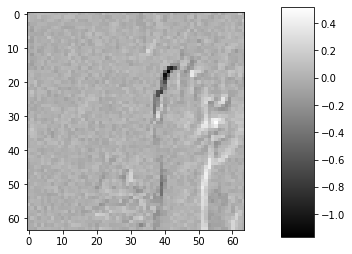

5.5257864


In [93]:
imagesc(I2_zero_check-I2)
print(np.linalg.norm(I2-I2_zero_check))

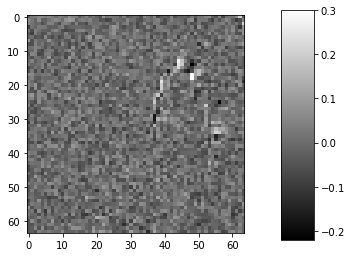

3.003193873032363


In [94]:
imagesc(I2_un_check-I2)
print(np.linalg.norm(I2-I2_un_check))

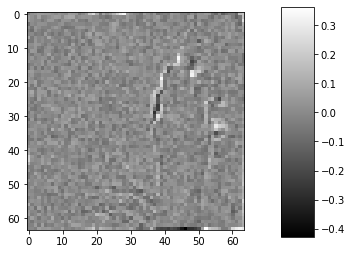

3.5658689


In [95]:
imagesc(I2_bis_check-I2)
print(np.linalg.norm(I2-I2_bis_check))

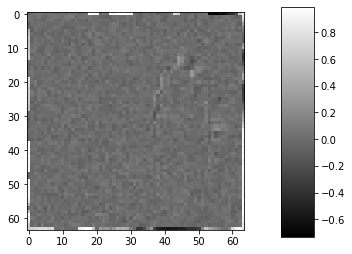

9.622266305115561


In [96]:
imagesc(I2_ter_check-I2)
print(np.linalg.norm(I2-I2_ter_check))

# Test on Real Videos (fast)

In [97]:
I1 = torch2numpy(x[3,0,:,:]);
I2 = torch2numpy(x[10,0,:,:]);

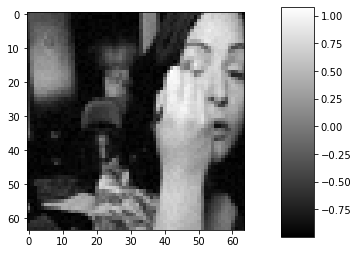

In [98]:
imagesc(I1)

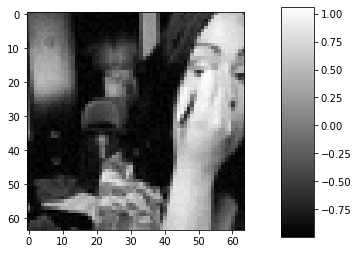

In [99]:
imagesc(I2)

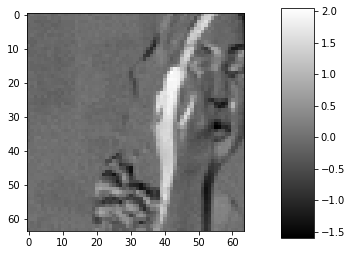

In [100]:
imagesc(I1-I2)

In [101]:
optical_flow = cv2.optflow.DualTVL1OpticalFlow_create(nscales=1,epsilon=0.05,warps=1, innnerIterations = 10);
optical_flow.setLambda(0.005) #0.005 is the breaking point
t1 = time.time();
flow = optical_flow.calc(I1, I2, None);
t2 = time.time();

In [102]:
t2-t1

0.0023221969604492188

In [103]:
u = flow[:,:,0];
v = flow[:,:,1];

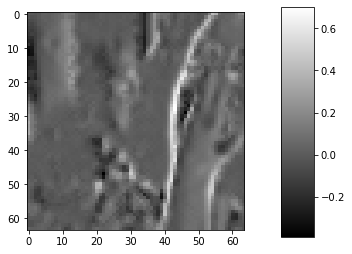

In [104]:
imagesc(u)

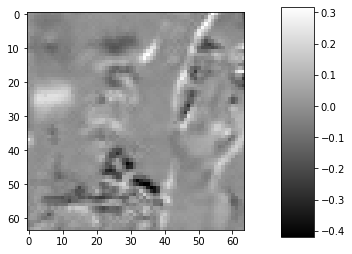

In [105]:
imagesc(v)

In [106]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

print("===========================================");
print("Warp error Skimage - = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy - = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv - = " + str(np.linalg.norm(I2-I2_bis_check)));
print("Warp error scipy-bis - = " + str(np.linalg.norm(I2-I2_ter_check)));
print("===========================================");

Identity error = 28.096087
Warp error Skimage - = 27.932072
Warp error scipy - = 27.716178447018166
Warp error opencv - = 27.424833
Warp error scipy-bis - = 28.675932101209963


In [107]:
I1_8_bit = float2_bit(I1);
I2_8_bit = float2_bit(I2);


# I1_8_bit = 255*(I1+1)/2
# I1_8_bit = I1_8_bit.astype('uint8')
# I2_8_bit = 255*(I2+1)/2
# I2_8_bit = I2_8_bit.astype('uint8')

In [108]:
t1 = time.time();
flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 10, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 10 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 
t2 = time.time();

In [109]:
t2-t1

0.0010228157043457031

In [110]:
u = flow[:,:,0];
v = flow[:,:,1];

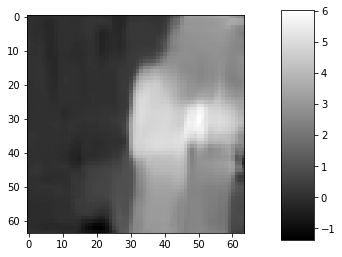

In [111]:
imagesc(u)

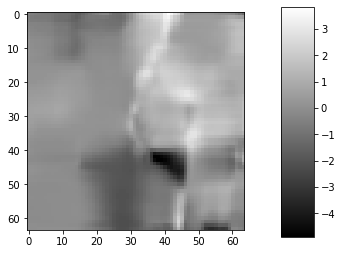

In [112]:
imagesc(v)

In [113]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

print("===========================================");
print("Warp error Skimage - = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy - = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv - = " + str(np.linalg.norm(I2-I2_bis_check)));
print("Warp error scipy-bis - = " + str(np.linalg.norm(I2-I2_ter_check)));
print("===========================================");

Identity error = 28.096087
Warp error Skimage - = 31.180758
Warp error scipy - = 12.642381402619762
Warp error opencv - = 12.519107
Warp error scipy-bis - = 14.282408971604283


In [114]:
np.random.seed(seed=1)
t1 = time.time();
flow = cv2.optflow.calcOpticalFlowSparseToDense(I1_8_bit, I2_8_bit, None); # Pas forcément top
t2 = time.time();

In [115]:
t2-t1

0.0027799606323242188

In [116]:
u = flow[:,:,0];
v = flow[:,:,1];

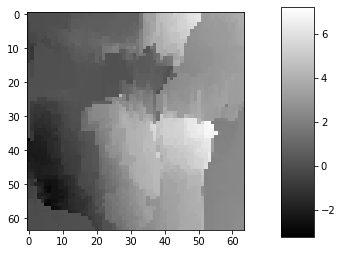

In [117]:
imagesc(u)

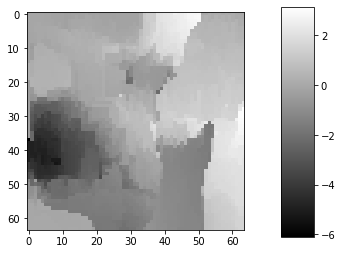

In [118]:
imagesc(v)

In [119]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

print("===========================================");
print("Warp error Skimage - = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy - = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv - = " + str(np.linalg.norm(I2-I2_bis_check)));
print("Warp error scipy-bis - = " + str(np.linalg.norm(I2-I2_ter_check)));
print("===========================================");

Identity error = 28.096087
Warp error Skimage - = 30.86053
Warp error scipy - = 20.638155087298802
Warp error opencv - = 20.24244
Warp error scipy-bis - = 21.396204792071128


## Visualisation of results on the Farneback algorithm

In [120]:
t1 = time.time();
flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 10, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 10 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 
t2 = time.time();

In [121]:
I2_zero_check = warp_zero(I1,-flow);
I2_un_check = warp_un(I1,-flow);
I2_bis_check = warp_bis(I1,-flow);
I2_ter_check = warp_trois(I1,-flow);

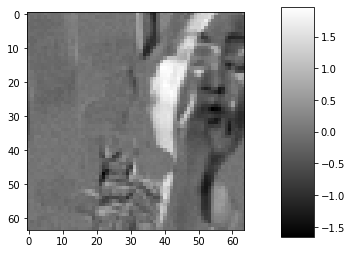

31.180758


In [122]:
imagesc(I2_zero_check-I2)
print(np.linalg.norm(I2-I2_zero_check))

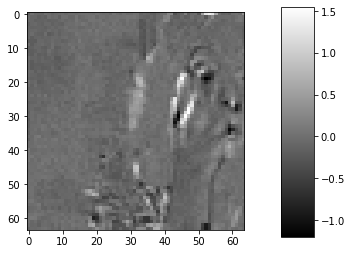

12.642381402619762


In [123]:
imagesc(I2_un_check-I2)
print(np.linalg.norm(I2-I2_un_check))

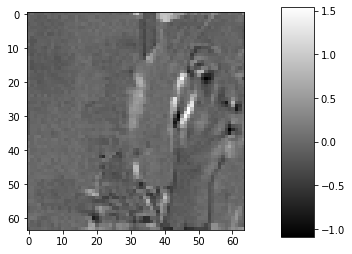

12.519107


In [124]:
imagesc(I2_bis_check-I2)
print(np.linalg.norm(I2-I2_bis_check))

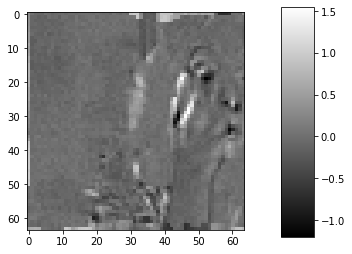

14.282408971604283


In [125]:
imagesc(I2_ter_check-I2)
print(np.linalg.norm(I2-I2_ter_check))

# Testing Linear model $u \cdot \nabla$

In [126]:
def grad_x_matrix_centered(nx, ny):
    Dupper = np.diag([1] * (nx-1), 1)
    Dlower = -np.diag([1] * (nx-1), -1)
    D = 1/2*(Dupper + Dlower)
    Ds = [D] * (nx)
    A  = block_diag(*Ds)
    return A

def grad_y_matrix_centered(nx, ny):
    I = np.ones((nx*(ny-1)))
    Iupper = np.diag(I, nx)
    Ilower = -np.diag(I, -(nx))
    A = 1/2*(Iupper + Ilower)
    return A

def next_matrix_centered(nx,ny, flow):
    Dx = grad_x_matrix_centered(nx, ny);
    Dy = grad_y_matrix_centered(nx, ny);
    Fx = np.diag(np.reshape(flow[:,:,0],(nx*ny)))@Dx;
    Fy = np.diag(np.reshape(flow[:,:,1],(nx*ny)))@Dy;
    F = Fx+Fy;
    return F

def warp_tetra_centered(I1, flow):
    nx, ny = I1.shape
    F = next_matrix_centered(nx,ny, flow)
    I1 = np.reshape(I1,(nx*ny));
    I2 = np.dot(F, I1);
    I2 = np.reshape(I2,(nx, ny));
    return I2;


def grad_x_matrix(nx, ny):
    Dupper = np.diag([1] * (nx-1), 1)
    Dlower = -np.diag([1] * (nx))
    D = Dupper + Dlower
    Ds = [D] * (nx)
    A  = block_diag(*Ds)
    return A

def grad_y_matrix(nx, ny):
    I = np.ones((nx*(ny-1)))
    Iupper = np.diag(I, nx)
    Ilower = -np.eye(nx*ny)
    A = Iupper + Ilower
    return A

def next_matrix(nx,ny, flow):
    Dx = grad_x_matrix(nx, ny);
    Dy = grad_y_matrix(nx, ny);
    Fx = np.diag(np.reshape(flow[:,:,0],(nx*ny)))@Dx;
    Fy = np.diag(np.reshape(flow[:,:,1],(nx*ny)))@Dy;
    F = Fx+Fy;
    return F

def warp_tetra(I1, flow):
    nx, ny = I1.shape
    F = next_matrix(nx,ny, flow)
    I1 = np.reshape(I1,(nx*ny));
    I2 = np.dot(F, I1);
    I2 = np.reshape(I2,(nx, ny));
    return I2;



## On a Fast video 

In [127]:
n_frames = 10;
A = boule_vid_parabola(64, 0.025, n_frames, 1)
A = torch.Tensor(A);
A = torch2numpy(A)

I1 = A[0,:,:].astype(np.float32);
I2 = A[1,:,:].astype(np.float32);
I1_8_bit = float2_bit(I1);
I2_8_bit = float2_bit(I2);

In [128]:
A_x = grad_x_matrix_centered(64,64)

In [129]:
A_x

array([[ 0. ,  0.5,  0. , ...,  0. ,  0. ,  0. ],
       [-0.5,  0. ,  0.5, ...,  0. ,  0. ,  0. ],
       [ 0. , -0.5,  0. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ...,  0. ,  0.5,  0. ],
       [ 0. ,  0. ,  0. , ..., -0.5,  0. ,  0.5],
       [ 0. ,  0. ,  0. , ...,  0. , -0.5,  0. ]])

In [130]:
A_x = grad_x_matrix(64,64)

In [131]:
A_x

array([[-1,  1,  0, ...,  0,  0,  0],
       [ 0, -1,  1, ...,  0,  0,  0],
       [ 0,  0, -1, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., -1,  1,  0],
       [ 0,  0,  0, ...,  0, -1,  1],
       [ 0,  0,  0, ...,  0,  0, -1]])

In [132]:
flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 10, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 10 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 

In [133]:
u = flow[:,:,0]
v = flow[:,:,1]

In [134]:
I = np.reshape(I1,(4096))

In [135]:
I2_prim = A_x@I

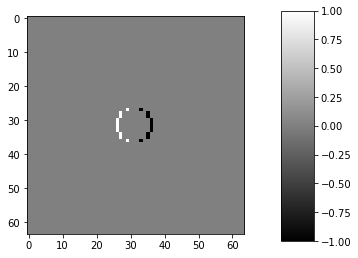

In [136]:
imagesc(np.reshape(I2_prim,(64,64)))

In [137]:
A_y = grad_y_matrix_centered(64,64)

In [138]:
np.sum(np.abs(A_y))

4032.0

In [139]:
A_y = grad_y_matrix(64,64)

In [140]:
A_y

array([[-1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -1.]])

In [141]:
I2_prim = A_y@I

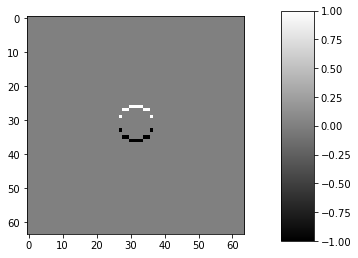

In [142]:
imagesc(np.reshape(I2_prim,(64,64)))

In [143]:
Fx = np.diag(np.reshape(flow[:,:,0],(64**2)))@A_x;
Fy = np.diag(np.reshape(flow[:,:,1],(64**2)))@A_y;

In [144]:
F = Fx+Fy

In [145]:
dt = 1/30
I_next = I - dt*F@I

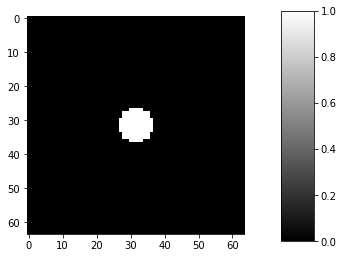

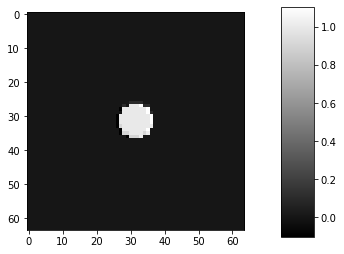

In [146]:
imagesc(np.reshape(I,(64,64)))
imagesc(np.reshape(I_next,(64,64)))

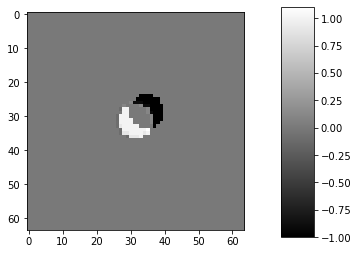

9.003404054416288


In [147]:
imagesc(np.reshape(I_next,(64,64))-I2)
print(np.linalg.norm(np.reshape(I_next,(64,64))-I2))

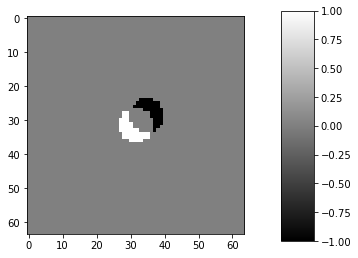

9.110434


In [148]:
imagesc(I1-I2)
print(np.linalg.norm(I1-I2))

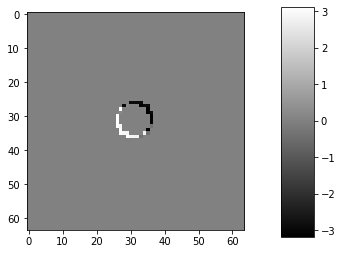

In [149]:
imagesc(np.reshape(F@I,(64,64)))

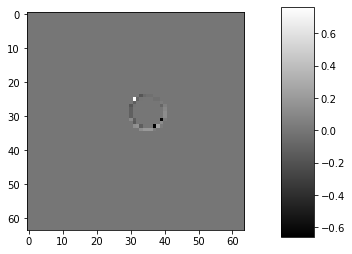

1.3900365


In [150]:
I2_bis_check = warp_bis(I1,-flow);
imagesc(I2_bis_check-I2)
print(np.linalg.norm(I2_bis_check-I2))

## On a slow video

In [151]:
n_frames = 100;
A = boule_vid_parabola(64, 0.025, n_frames, 1)
A = torch.Tensor(A);
A = torch2numpy(A)

I1 = A[0,:,:].astype(np.float32);
I2 = A[1,:,:].astype(np.float32);
I1_8_bit = float2_bit(I1);
I2_8_bit = float2_bit(I2);

In [152]:
flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 10, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 10 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 

In [153]:
u = flow[:,:,0]
v = flow[:,:,1]

In [154]:
I = np.reshape(I1,(4096))

In [155]:
I2_prim = A_x@I

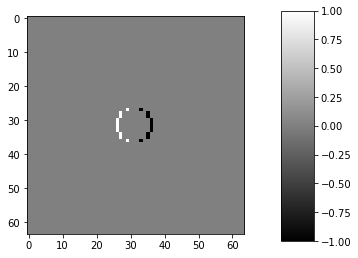

In [156]:
imagesc(np.reshape(I2_prim,(64,64)))

In [157]:
I2_prim = A_y@I

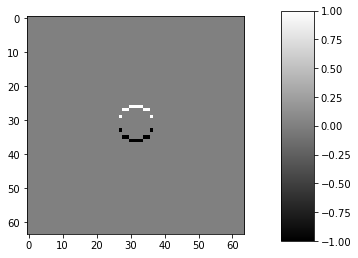

In [158]:
imagesc(np.reshape(I2_prim,(64,64)))

In [159]:
Fx = np.diag(np.reshape(flow[:,:,0],(64**2)))@A_x;
Fy = np.diag(np.reshape(flow[:,:,1],(64**2)))@A_y;

In [160]:
F = Fx+Fy

In [167]:
dt = 1/30
I_next = I - F@I

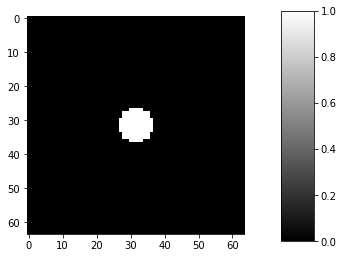

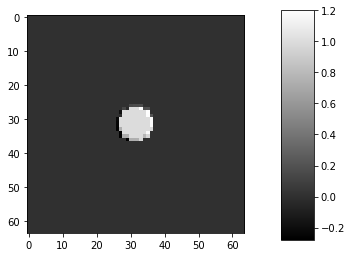

In [168]:
imagesc(np.reshape(I,(64,64)))
imagesc(np.reshape(I_next,(64,64)))

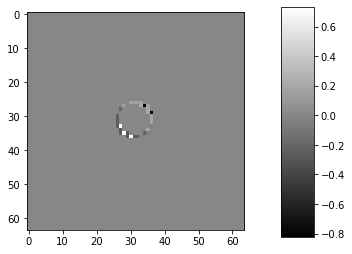

2.0137258091024215


In [169]:
imagesc(np.reshape(I_next,(64,64))-I2)
print(np.linalg.norm(np.reshape(I_next,(64,64))-I2))

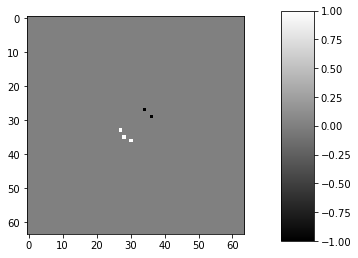

2.236068


In [170]:
imagesc(I1-I2)
print(np.linalg.norm(I1-I2))

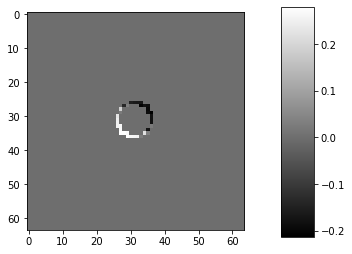

In [171]:
imagesc(np.reshape(F@I,(64,64)))

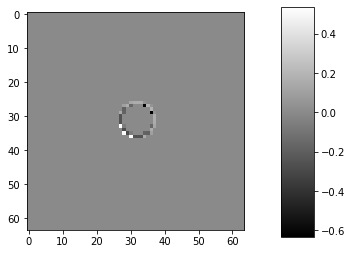

1.65687


In [172]:
I2_bis_check = warp_bis(I1,-flow);
imagesc(I2_bis_check-I2)
print(np.linalg.norm(I2_bis_check-I2))